<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [10]:
#!if [ -d deepul ]; then rm -Rf deepul; fi
#!git clone https://github.com/rll/deepul.git
#!pip install ./deepul
#!pip install scikit-learn

%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [11]:
%cd ~/workspace/github/

# !pip install -e .

/private/home/dongwang/workspace/github


In [12]:
from deepul.hw4_helper import *
import warnings
warnings.filterwarnings('ignore')

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

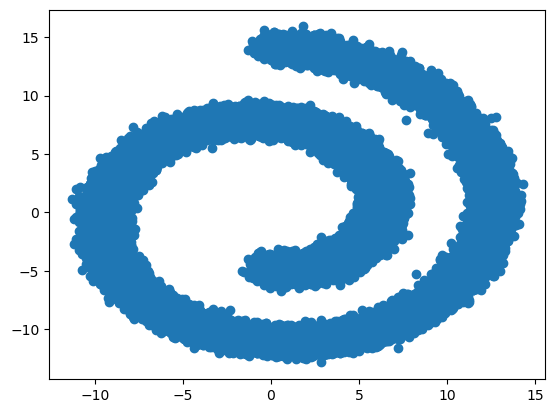

In [13]:
visualize_q1_dataset()

In [14]:
q1_data(n=10)

array([[  7.975615  ,  -7.941924  ],
       [ -0.31984776,  14.769583  ],
       [ -9.538685  ,   0.42327958],
       [ -8.998367  ,  -1.0546353 ],
       [  6.2887173 ,   0.6932945 ],
       [  5.682582  ,   4.3001184 ],
       [  5.516726  ,  -1.8948873 ],
       [ -0.45630032, -11.122738  ],
       [  4.713243  ,   6.2805624 ],
       [  2.807246  , -10.956384  ]], dtype=float32)

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

device = torch.device("cuda")

def DDPM_UPDATE(x: torch.Tensor, eps_hat: torch.Tensor, t: float, tm1: float) -> torch.Tensor:
    alpha_t = torch.cos(np.pi / 2 * t)
    sigma_t = torch.sin(np.pi / 2 * t)
    alpha_tm1 = torch.cos(np.pi / 2 * tm1)
    sigma_tm1 = torch.sin(np.pi / 2 * tm1)
    eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - (alpha_t ** 2 / alpha_tm1 ** 2))
    eps_t = torch.randn_like(x)
    term1 = alpha_tm1 * ((x - sigma_t * eps_hat) / alpha_t)
    term2 = torch.sqrt(torch.clamp(sigma_tm1 ** 2 - eta_t ** 2, min=0)) * eps_hat
    term3 = eta_t * eps_t
    return term1 + term2 + term3

def sample(model: torch.nn.Module, num_steps: int, num_samples: int) -> np.ndarray:
    x = torch.randn(num_samples, 2, device=device)
    ts = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1, device=device)
    for i in range(num_steps):
        t = ts[i]
        tm1 = ts[i + 1]
        # Prepare model input
        t_expanded = t.expand(num_samples, 1)
        input = torch.cat((x, t_expanded), dim=-1)
        # Model prediction for eps_hat
        eps_hat = model(input)
        # Update x using the DDPM update rule
        x = DDPM_UPDATE(x, eps_hat, t, tm1)
    return x.cpu().detach().numpy()

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.layers(x)

    def loss(self, mini_batch: np.ndarray):
        mini_batch = torch.tensor(mini_batch).to(device)
        # Sample the diffusion timestep
        t = np.random.uniform(0, 1, size=(mini_batch.shape[0], 1)).astype(np.float32)
        t = torch.tensor(t).to(device)
        alpha_t = torch.cos(np.pi / 2 * t)
        sigma_t = torch.sin(np.pi / 2 * t)
        # Apply the forward process
        epsilon = torch.randn_like(mini_batch).to(device)
        x_t = alpha_t * mini_batch + sigma_t * epsilon
        input = torch.cat((x_t, t), dim=-1)
        epsilon_hat = self(input)
        # Optimize the loss
        loss1 = torch.mean((epsilon - epsilon_hat) ** 2)
        return loss1


def loss(model, test_data, batch_size):
  losses = []
  for i in range(test_data.shape[0] // batch_size):
    input_data = test_data[i*batch_size : (i+1)*batch_size]
    with torch.no_grad():
      losses.append(model.loss(input_data).cpu().item())

  return np.mean(losses)

def q1(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """
    # each data is a 2d point
    mean, std = np.mean(train_data, axis=0), np.std(train_data, axis=0)
    train_data = ((train_data - mean) / std).astype(np.float32)
    test_data = ((test_data - mean) / std).astype(np.float32)

    num_epochs = 100
    batch_size = 1024
    learning_rate = 1e-3
    warmup_steps = 100
    total_steps = num_epochs * (train_data.shape[0] // batch_size)

    test_losses = []
    train_losses = []

    model = MLP(3, 64, 2).to(device)
    model.eval()
    test_losses.append(loss(model, test_data, batch_size))
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Scheduler
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            return 0.5 * (1 + torch.cos(torch.tensor((step - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
    scheduler = LambdaLR(optimizer, lr_lambda)

    for i in range(num_epochs):
        model.train()
        np.random.shuffle(train_data)
        for j in range(0, len(train_data), batch_size):
            mini_batch = train_data[j: j+batch_size]
            loss1 = model.loss(mini_batch)
            train_losses.append(loss1.cpu().item())
            optimizer.zero_grad()
            loss1.backward()
            optimizer.step()
            scheduler.step()
        model.eval()
        test_losses.append(loss(model, test_data, batch_size))

    all_samples = []
    for step in np.power(2, np.linspace(0, 9, 9)).astype(int):
        all_samples.append(sample(model, step, 2000))
    all_samples = np.array(all_samples)
    all_samples = all_samples * std + mean
    return train_losses, test_losses, all_samples

Final Test Loss: 0.4269


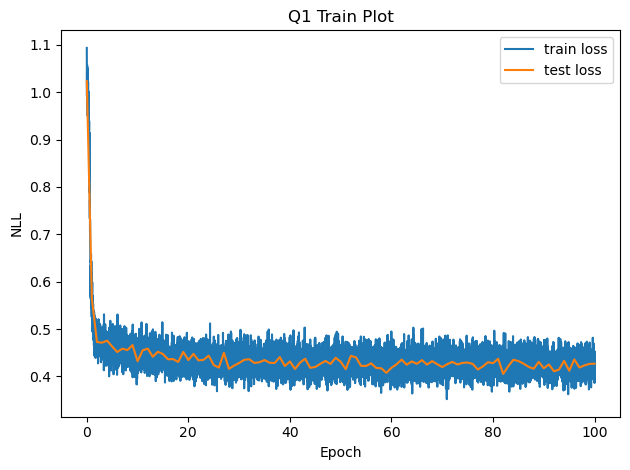

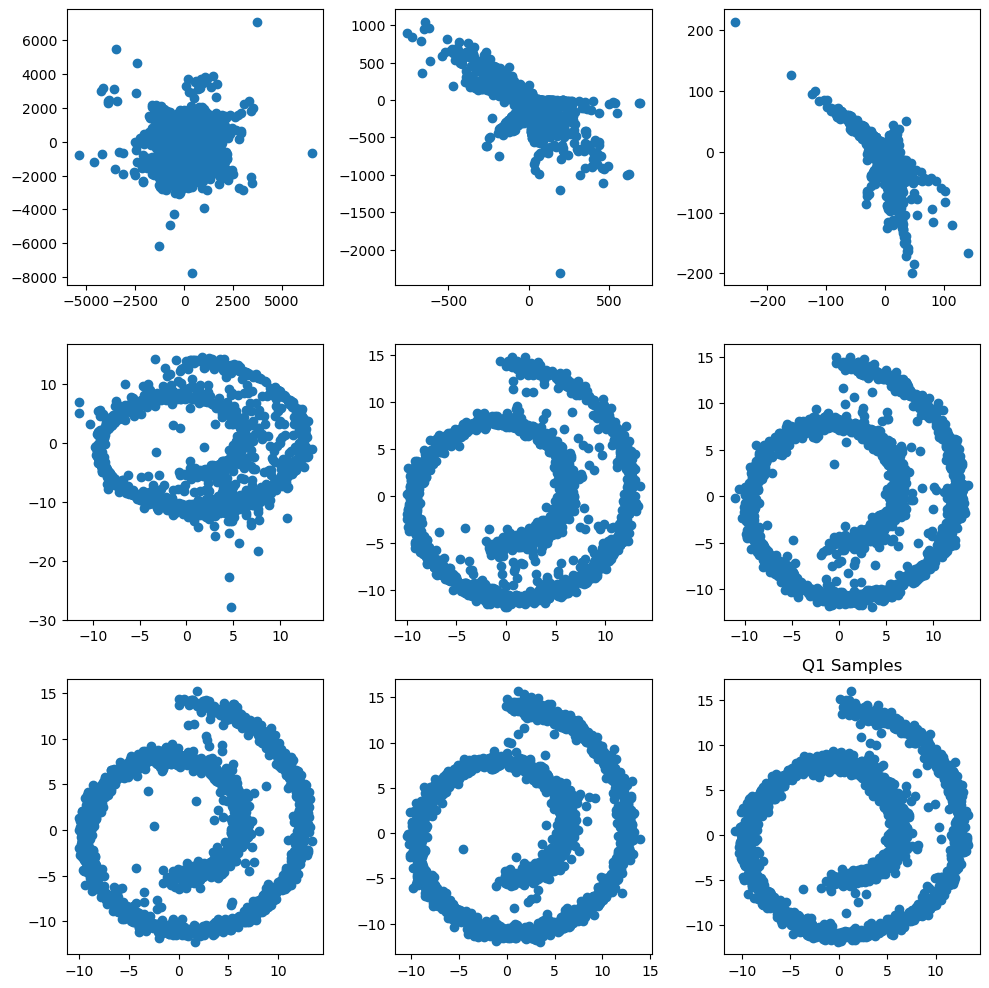

In [38]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


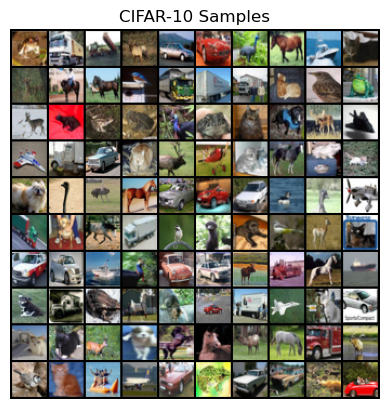

In [16]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [17]:
# original unet https://github.com/sauravmishra1710/U-Net---Biomedical-Image-Segmentation/blob/main/UNet%20-%20Biomedical_Segmentation.ipynb
# cross is before downsample and connect to the other side after upsample. they are concat to double channel, then conv reduce channel to half.
#unet with time https://www.kaggle.com/code/vikramsandu/ddpm-from-scratch-in-pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def DDPM_UPDATE(x: torch.Tensor, eps_hat: torch.Tensor, t: float, tm1: float) -> torch.Tensor:
    alpha_t = torch.cos(np.pi / 2 * t)
    sigma_t = torch.sin(np.pi / 2 * t)
    alpha_tm1 = torch.cos(np.pi / 2 * tm1)
    sigma_tm1 = torch.sin(np.pi / 2 * tm1)
    eta_t = sigma_tm1 / sigma_t * torch.sqrt(1 - (alpha_t ** 2 / alpha_tm1 ** 2))
    eps_t = torch.randn_like(x)
    term1 = alpha_tm1 * torch.clamp((x - sigma_t * eps_hat) / alpha_t, min=-1, max=1)
    term2 = torch.sqrt(torch.clamp(sigma_tm1 ** 2 - eta_t ** 2, min=0)) * eps_hat
    term3 = eta_t * eps_t
    return term1 + term2 + term3

def q2_sample(model: torch.nn.Module, num_steps: int, num_samples: int) -> np.ndarray:
    model.eval()
    x = torch.randn(num_samples, 3, 32, 32, device=device)
    ts = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1, device=device)
    for i in range(num_steps):
        # print(f"Allocated CUDA memory: {torch.cuda.memory_allocated(device) / (1024 * 1024)} MB")

        t = ts[i]
        tm1 = ts[i + 1]
        # Prepare model input
        t_expanded = t.expand(num_samples, 1)
        # Model prediction for eps_hat
        with torch.no_grad():
            eps_hat = model(x, t_expanded)
        # Update x using the DDPM update rule
        x = DDPM_UPDATE(x, eps_hat, t, tm1)
    return x.cpu().permute(0, 2, 3, 1).detach().numpy()


class TimestepEmbedding(nn.Module):
    def __init__(self, dim, max_period=10000):
        super().__init__()
        self.dim = dim
        self.max_period = max_period
    def forward(self, timesteps):
        half_dim = self.dim // 2
        freqs = torch.exp(-np.log(self.max_period) * torch.arange(0, half_dim, dtype=torch.float32) / half_dim)
        args = timesteps[:, None].to(freqs.device) * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if self.dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding[:, 0, :].to(device)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, temb_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.temb_proj = nn.Linear(temb_channels, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        if in_channels != out_channels:
            self.proj = nn.Conv2d(in_channels, out_channels, 1)
    def forward(self, x, temb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.silu(h)
        temb = self.temb_proj(temb)
        h += temb[:, :, None, None]
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.silu(h)
        if hasattr(self, 'proj'):
            x = self.proj(x)
        return x + h
class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, stride=2, padding=1)
    def forward(self, x):
        return self.conv(x)
class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

"""
Input Image [3, 32, 32]
    ↓
Initial Conv [64] h[0]
    ↓
ResBlock [64] → ResBlock [64] → Downsample h[1,2,3]
    ↓
ResBlock [128] → ResBlock [128] → Downsample h[4,5,6]
    ↓
ResBlock [256] → ResBlock [256] → Downsample h[7,8,9]
    ↓
ResBlock [512] → ResBlock [512] h[10, 11]
    ↓
Bottleneck: ResBlock [512] → ResBlock [512]
    ↓
ResBlock [512] → ResBlock [512] → ResBlock [512] h[11,10,9]
    ↓
ResBlock [256] → ResBlock [256] → ResBlock [256] → Upsample h[8,7,6]
    ↓
ResBlock [128] → ResBlock [128] → ResBlock [128] → Upsample h[5,4,3]
    ↓
ResBlock [64] → ResBlock [64] → ResBlock [64] → Upsample h[2,1,0]
    ↓
GroupNorm → SiLU → Final Conv [3]
    ↓
Output Image [3, 32, 32]
"""    
class UNet(nn.Module):
    def __init__(self, in_channels, hidden_dims, blocks_per_dim):
        super().__init__()
        temb_channels = hidden_dims[0] * 4
        self.timestep_embedding = TimestepEmbedding(hidden_dims[0])
        self.temb_proj = nn.Sequential(
            nn.Linear(hidden_dims[0], temb_channels),
            nn.SiLU(),
            nn.Linear(temb_channels, temb_channels)
        )
        self.initial_conv = nn.Conv2d(in_channels, hidden_dims[0], 3, padding=1)
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        prev_ch = hidden_dims[0]
        down_block_chans = [prev_ch]
        for i, hidden_dim in enumerate(hidden_dims):
            for _ in range(blocks_per_dim):
                self.down_blocks.append(ResidualBlock(prev_ch, hidden_dim, temb_channels))
                prev_ch = hidden_dim
                down_block_chans.append(prev_ch)
            if i != len(hidden_dims) - 1:
                self.down_blocks.append(Downsample(prev_ch))
                down_block_chans.append(prev_ch)
        self.mid_blocks = nn.ModuleList()
        self.mid_blocks.append(
            ResidualBlock(prev_ch, prev_ch, temb_channels))
        self.mid_blocks.append(
            ResidualBlock(prev_ch, prev_ch, temb_channels)
        )
        for i, hidden_dim in reversed(list(enumerate(hidden_dims))):
            for _ in range(blocks_per_dim + 1):
                self.up_blocks.append(ResidualBlock(prev_ch+down_block_chans.pop(), hidden_dim, temb_channels))
                prev_ch = hidden_dim
            if i:
                self.up_blocks.append(Upsample(prev_ch))
        self.final_norm = nn.GroupNorm(num_groups=8, num_channels=prev_ch)
        self.final_conv = nn.Conv2d(prev_ch, in_channels, 3, padding=1)
    def forward(self, x, t):
        # Embed the timestep
        temb1 = self.timestep_embedding(t)
        temb = self.temb_proj(temb1)
        # Initial convolution
        h = self.initial_conv(x)
        hs = [h]
        # Downward pass through the UNet
        for block in self.down_blocks:
            h = block(h, temb) if isinstance(block, ResidualBlock) else block(h)
            hs.append(h)
        assert len(hs) == 12
        # Middle blocks
        for block in self.mid_blocks:
            h = block(h, temb)
        # Upward pass through the UNet
        for block in self.up_blocks:
            if isinstance(block, Upsample):
                h = block(h)
            else:
                skip_connection = hs.pop()
                h = torch.cat([h, skip_connection], dim=1)
                h = block(h, temb)
        # Final normalization and convolution
        h = self.final_norm(h)
        h = F.silu(h)
        out = self.final_conv(h)
        return out

    def loss(self, mini_batch: np.ndarray):
        mini_batch = torch.from_numpy(mini_batch).permute(0, 3, 1, 2).to(device)
        # Sample the diffusion timestep
        t = np.random.uniform(0, 1, size=(mini_batch.shape[0], 1)).astype(np.float32)
        t = torch.tensor(t).to(device)
        alpha_t = torch.cos(np.pi / 2 * t)[:, :, None, None]
        sigma_t = torch.sin(np.pi / 2 * t)[:, :, None, None]
        # Apply the forward process
        epsilon = torch.randn_like(mini_batch).to(device)
        x_t = alpha_t * mini_batch + sigma_t * epsilon
        epsilon_hat = self(x_t, t)
        # Optimize the loss
        loss1 = torch.mean((epsilon - epsilon_hat) ** 2)
        return loss1
       


In [18]:
import tqdm
def q2(train_data, test_data):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
      1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    """ YOUR CODE HERE """
    #  data is between 0 and 1
    # mean, std = train_data.mean(), train_data.std()
    mean, std = 0.5, 0.5
    train_data = ((train_data - mean) / std).astype(np.float32)
    test_data = ((test_data - mean) / std).astype(np.float32)

    num_epochs = 60  # blows up at 35
    batch_size = 256
    learning_rate = 1e-3
    warmup_steps = 100
    total_steps = num_epochs * (train_data.shape[0] // batch_size)

    test_losses = []
    train_losses = []

    model = UNet(3, [64, 128, 256, 512], 2).to(device)
    model.eval()
    test_losses.append(loss(model, test_data, batch_size*3))
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Scheduler
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            return 0.5 * (1 + torch.cos(torch.tensor((step - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
    scheduler = LambdaLR(optimizer, lr_lambda)

    checkpoint_path = 'deepul/homeworks/hw4/data/model_q2.pth'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
    else:
        assert os.path.exists(os.path.dirname(checkpoint_path))
        for i in tqdm.tqdm(range(num_epochs)):
            model.train()
            np.random.shuffle(train_data)
            for j in range(0, len(train_data), batch_size):
                mini_batch = train_data[j:j+batch_size]
                loss1 = model.loss(mini_batch)
                train_losses.append(loss1.cpu().item())
                optimizer.zero_grad()
                loss1.backward()
                optimizer.step()
                scheduler.step()
            model.eval()
            this_loss = loss(model, test_data, batch_size*3)
            test_losses.append(this_loss)
            print(f"epoch={i}, loss={this_loss}")

        torch.save(model.state_dict(), checkpoint_path)


    all_samples = []
    for step in np.power(2, np.linspace(0, 9, 9)).astype(int):
        all_samples.append(q2_sample(model, step, 10))
    all_samples = np.array(all_samples)
    all_samples = all_samples * std + mean
    np.save('deepul/homeworks/hw4/data/all_samples.npy', all_samples)

    return train_losses, test_losses, all_samples

In [40]:
q2_save_results(q2)

Files already downloaded and verified
Files already downloaded and verified


  2%|███▍                                                                                                                                                                                                        | 1/60 [00:26<26:00, 26.45s/it]

epoch=0, loss=0.09556348908406037


  3%|██████▊                                                                                                                                                                                                     | 2/60 [00:53<25:58, 26.87s/it]

epoch=1, loss=0.07575363723131326


  5%|██████████▏                                                                                                                                                                                                 | 3/60 [01:20<25:43, 27.08s/it]

epoch=2, loss=0.07591419552381222


  7%|█████████████▌                                                                                                                                                                                              | 4/60 [01:48<25:21, 27.17s/it]

epoch=3, loss=0.07164144229430419


  8%|█████████████████                                                                                                                                                                                           | 5/60 [02:15<24:55, 27.18s/it]

epoch=4, loss=0.06982571860918632


 10%|████████████████████▍                                                                                                                                                                                       | 6/60 [02:42<24:29, 27.22s/it]

epoch=5, loss=0.0693224069590752


 12%|███████████████████████▊                                                                                                                                                                                    | 7/60 [03:09<24:01, 27.19s/it]

epoch=6, loss=0.06826951297429892


 13%|███████████████████████████▏                                                                                                                                                                                | 8/60 [03:37<23:35, 27.23s/it]

epoch=7, loss=0.06796487048268318


 15%|██████████████████████████████▌                                                                                                                                                                             | 9/60 [04:04<23:09, 27.24s/it]

epoch=8, loss=0.0667736899967377


 17%|█████████████████████████████████▊                                                                                                                                                                         | 10/60 [04:31<22:42, 27.25s/it]

epoch=9, loss=0.06722131801339296


 18%|█████████████████████████████████████▏                                                                                                                                                                     | 11/60 [04:59<22:15, 27.26s/it]

epoch=10, loss=0.06632914594732799


 20%|████████████████████████████████████████▌                                                                                                                                                                  | 12/60 [05:26<21:47, 27.25s/it]

epoch=11, loss=0.06432058891424766


 22%|███████████████████████████████████████████▉                                                                                                                                                               | 13/60 [05:53<21:20, 27.25s/it]

epoch=12, loss=0.06626415281341626


 23%|███████████████████████████████████████████████▎                                                                                                                                                           | 14/60 [06:20<20:54, 27.28s/it]

epoch=13, loss=0.06533305404277948


 25%|██████████████████████████████████████████████████▊                                                                                                                                                        | 15/60 [06:48<20:27, 27.29s/it]

epoch=14, loss=0.06618730981762593


 27%|██████████████████████████████████████████████████████▏                                                                                                                                                    | 16/60 [07:15<20:00, 27.28s/it]

epoch=15, loss=0.06396938430575225


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                 | 17/60 [07:42<19:31, 27.25s/it]

epoch=16, loss=0.06680682989267203


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                              | 18/60 [08:09<19:05, 27.27s/it]

epoch=17, loss=0.0626667242210645


 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                          | 19/60 [08:37<18:36, 27.24s/it]

epoch=18, loss=0.0645555378152774


 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                       | 20/60 [09:04<18:09, 27.24s/it]

epoch=19, loss=0.06339047877834393


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                    | 21/60 [09:31<17:42, 27.24s/it]

epoch=20, loss=0.06479593337728427


 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 22/60 [09:58<17:14, 27.23s/it]

epoch=21, loss=0.06364045865260638


 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 23/60 [10:26<16:47, 27.24s/it]

epoch=22, loss=0.06228143607194607


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 24/60 [10:53<16:19, 27.22s/it]

epoch=23, loss=0.065429665434819


 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 25/60 [11:20<15:53, 27.24s/it]

epoch=24, loss=0.0658044875241243


 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 26/60 [11:47<15:26, 27.24s/it]

epoch=25, loss=0.06373626738786697


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 27/60 [12:15<14:59, 27.26s/it]

epoch=26, loss=0.06239906354592396


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 28/60 [12:42<14:31, 27.23s/it]

epoch=27, loss=0.06483080954505847


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 29/60 [13:09<14:03, 27.20s/it]

epoch=28, loss=0.06261637004522178


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 30/60 [13:36<13:35, 27.20s/it]

epoch=29, loss=0.0646653610926408


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 31/60 [14:03<13:09, 27.21s/it]

epoch=30, loss=0.06255540165763634


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 32/60 [14:30<12:42, 27.22s/it]

epoch=31, loss=0.06104866357950064


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 33/60 [14:58<12:15, 27.22s/it]

epoch=32, loss=0.06230932072951244


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 34/60 [15:25<11:48, 27.24s/it]

epoch=33, loss=0.06312265361730869


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 35/60 [15:52<11:22, 27.30s/it]

epoch=34, loss=0.06365217469059505


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 36/60 [16:20<10:54, 27.29s/it]

epoch=35, loss=0.06222824408457829


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 37/60 [16:47<10:27, 27.29s/it]

epoch=36, loss=0.06439413158939435


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 38/60 [17:14<09:59, 27.27s/it]

epoch=37, loss=0.06310374490343608


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 39/60 [17:41<09:32, 27.27s/it]

epoch=38, loss=0.06313191870084175


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 40/60 [18:09<09:05, 27.27s/it]

epoch=39, loss=0.060432855326395765


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 41/60 [18:36<08:38, 27.29s/it]

epoch=40, loss=0.062319953281145826


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 42/60 [19:03<08:11, 27.28s/it]

epoch=41, loss=0.06081881717993663


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 43/60 [19:31<07:43, 27.24s/it]

epoch=42, loss=0.06116016065845123


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 44/60 [19:58<07:16, 27.26s/it]

epoch=43, loss=0.06272057386545035


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 45/60 [20:25<06:48, 27.24s/it]

epoch=44, loss=0.06264353801424687


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 46/60 [20:52<06:21, 27.24s/it]

epoch=45, loss=0.061526980537634626


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 47/60 [21:20<05:54, 27.27s/it]

epoch=46, loss=0.06206439836667134


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 48/60 [21:47<05:27, 27.25s/it]

epoch=47, loss=0.06129079741927294


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 49/60 [22:14<04:59, 27.26s/it]

epoch=48, loss=0.06168218300892757


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 50/60 [22:41<04:32, 27.26s/it]

epoch=49, loss=0.061382489995314524


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 51/60 [23:09<04:05, 27.32s/it]

epoch=50, loss=0.062196071904439196


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 52/60 [23:36<03:38, 27.31s/it]

epoch=51, loss=0.06403325927945283


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 53/60 [24:03<03:11, 27.30s/it]

epoch=52, loss=0.062181791147360437


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 54/60 [24:31<02:43, 27.29s/it]

epoch=53, loss=0.06235994599186457


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 55/60 [24:58<02:16, 27.30s/it]

epoch=54, loss=0.05995249662261743


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 56/60 [25:25<01:49, 27.28s/it]

epoch=55, loss=0.061861646290008836


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 57/60 [25:52<01:21, 27.28s/it]

epoch=56, loss=0.060965437728625074


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 58/60 [26:20<00:54, 27.26s/it]

epoch=57, loss=0.060085694663799726


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 59/60 [26:47<00:27, 27.23s/it]

epoch=58, loss=0.06328643715152374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [27:14<00:00, 27.24s/it]

epoch=59, loss=0.061205604328558996


TypeError: UNet.forward() missing 1 required positional argument: 't'

Files already downloaded and verified
Files already downloaded and verified
Final Test Loss: 1.1737


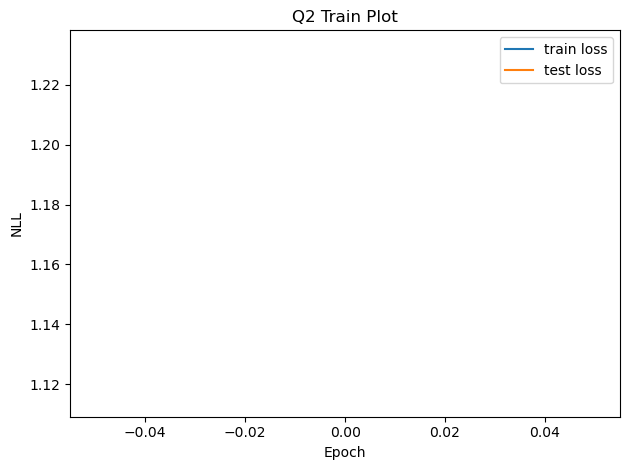

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


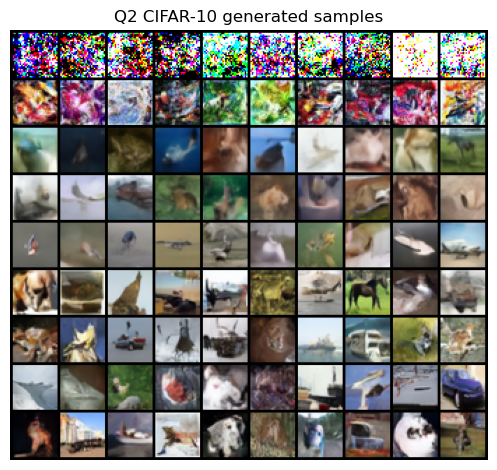

In [43]:
q2_save_results(q2)

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


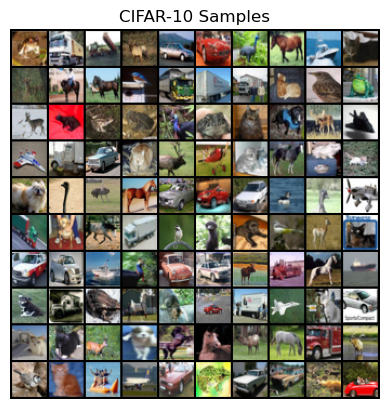

Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1]


In [19]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [20]:
# @property
# def latent_shape(self) -> Tuple[int, int, int]:
#     """Size of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [21]:
def q3_a(images, vae):
    """
    images: (1000, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (50, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
      of real and reconstructed images
    - a float that is the scale factor
    """

    """ YOUR CODE HERE """
    batch_size = 50
    zs = []
    for index in range(0, images.shape[0], batch_size):
        mini_batch1 = images[index:index+batch_size]
        mini_batch = np.transpose(mini_batch1, (0, 3, 1, 2))
        mini_batch = (mini_batch - 0.5) / 0.5 
        encoded = vae.encode(mini_batch)
        print(encoded.shape)
        if index == 0:
            decoded = vae.decode(encoded).cpu().numpy()
            decoded = (decoded * 0.5 + 0.5)
            decoded = np.transpose(decoded, (0, 2, 3, 1))
            print(mini_batch.shape, decoded.shape)
            autoencoded_images = np.stack((mini_batch1, decoded), axis=1)
        zs.append(encoded.cpu().numpy())
    scale_factor = np.std(np.array(zs))

    return autoencoded_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50, 4, 8, 8])
(50, 3, 32, 32) (50, 32, 32, 3)
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])
torch.Size([50, 4, 8, 8])


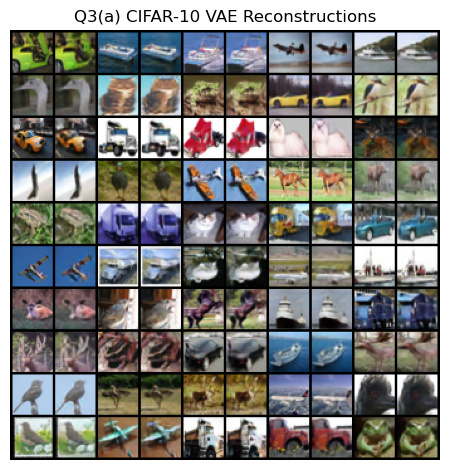

Scale factor: 1.2739


In [22]:
q3a_save_results(q3_a)

In [23]:
import torch
data = torch.ones(1, 4, 10, 10)
folded = torch.nn.functional.unfold(data, kernel_size=(2, 2), stride=(2,2))
print(folded.shape)
back = torch.nn.functional.fold(folded, (10, 10), kernel_size=(2, 2), stride=(2,2))
print(back.shape, back.min(), back.max())
(data != back).sum()


torch.Size([1, 16, 25])
torch.Size([1, 4, 10, 10]) tensor(1.) tensor(1.)


tensor(0)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0  # No shape, just a check
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0  # No shape, just a check
    omega = np.arange(embed_dim // 2, dtype=np.float64)  # (D/2,)
    omega /= embed_dim / 2.  # (D/2,)
    omega = 1. / 10000**omega  # (D/2,)
    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product
    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)
    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb
def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)  # (H,)
    grid_w = np.arange(grid_size, dtype=np.float32)  # (W,)
    grid = np.meshgrid(grid_w, grid_h)  # [(W, H), (W, H)] - meshgrid output
    grid = np.stack(grid, axis=0)  # (2, W, H)
    grid = grid.reshape([2, 1, grid_size, grid_size])  # (2, 1, H, W)
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    return torch.tensor(pos_embed).cuda()

class Attention(nn.Module):
  def __init__(self, d_model, n_heads):
    super(Attention, self).__init__()

    self.n_heads = n_heads
    self.d_model = d_model
    self.dim = self.d_model // self.n_heads

    self.layer_norm1 = nn.LayerNorm(d_model)
    self.w = nn.Linear(d_model, 3*d_model, bias=False)
    self.proj = nn.Linear(d_model, d_model, bias=False)



  def forward(self, x):
    bl = x.shape[1]
    mask = torch.tril(torch.ones((bl, bl), dtype=torch.float32)).cuda()
    x = self.layer_norm1(x)
    qkv = self.w(x)
    q, k, v = torch.split(qkv, self.d_model, -1)
    ys = []
    for i in range(self.n_heads):
      qq = q[:, :, i*self.dim : (i+1)*self.dim]
      kk = k[:, :, i*self.dim : (i+1)*self.dim]
      vv = v[:, :, i*self.dim : (i+1)*self.dim]
      att = qq @ kk.transpose(1, 2)
      att = att / np.sqrt(self.dim)
      att = att.masked_fill(mask[:bl, :bl] == 0, float('-inf'))
      att = att.softmax(dim=-1)
      ys.append(att @ vv)
    y = torch.cat(ys, dim=-1)
    y = self.proj(y)
    return y
  
class MyMLP(nn.Module):
  def __init__(self, d_model):
    super(MyMLP, self).__init__()

    self.d_model = d_model

    self.ffn = nn.Sequential(
      nn.LayerNorm(d_model),
      nn.Linear(self.d_model, self.d_model*4, bias=False),
      nn.SiLU(),
      nn.Linear(self.d_model*4, self.d_model, bias=False),
      nn.SiLU(),
    )


  def forward(self, x):
    y = self.ffn(x)
    return y

class DiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.attention = Attention(hidden_size, num_heads)
        self.mlp = MyMLP(hidden_size)
        self.silu = nn.SiLU()
        self.linear_c = nn.Linear(hidden_size, 6 * hidden_size)

    def modulate(self, x, shift, scale):
        return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)
    def forward(self, x, c):
        c = self.silu(c)
        c = self.linear_c(c)
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
        h = self.norm1(x)
        h = self.modulate(h, shift_msa, scale_msa)
        x = x + gate_msa.unsqueeze(1) * self.attention(h)
        h = self.norm2(x)
        h = self.modulate(h, shift_mlp, scale_mlp)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(h)
        return x
class FinalLayer(nn.Module):
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm = nn.LayerNorm(hidden_size, elementwise_affine=False)
        self.silu = nn.SiLU()
        self.patch_size = patch_size
        self.out_channels = out_channels
        self.linear_c = nn.Linear(hidden_size, 2*hidden_size)
        self.linear_x = nn.Linear(hidden_size, patch_size*patch_size*out_channels)
    def forward(self, x, c):
        c = self.silu(c)
        c = self.linear_c(c)
        shift, scale = c.chunk(2, dim=1)
        x = self.norm(x)
        x = x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)
        x = self.linear_x(x)
        return x

class DiT(nn.Module):
    def __init__(self, input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.patch_size = patch_size
        self.grid_size = input_shape[1] // patch_size
        self.num_layers = num_layers
        self.dropout_prob = cfg_dropout_prob
        self.num_classes = num_classes
        self.linear = nn.Linear(patch_size * patch_size * input_shape[0], hidden_size)
        self.embedding = nn.Embedding(num_classes + 1, hidden_size)
        self.blocks = nn.ModuleList([DiTBlock(hidden_size, num_heads) for _ in range(num_layers)])
        self.final_layer = FinalLayer(hidden_size, patch_size, input_shape[0])

        temb_channels = hidden_size
        self.timestep_embedding = TimestepEmbedding(hidden_size)
        self.temb_proj = nn.Sequential(
            nn.Linear(hidden_size, temb_channels),
            nn.SiLU(),
            nn.Linear(temb_channels, temb_channels)
        )
    def forward(self, x, y, t):
        # Patchify and flatten
        # https://mrinath.medium.com/vit-part-1-patchify-images-using-pytorch-unfold-716cd4fd4ef6
        x = nn.functional.unfold(x, kernel_size=(self.patch_size, self.patch_size), stride=(self.patch_size, self.patch_size)) # B, c*p*p, length
        x = x.permute(0, 2, 1).contiguous()
        x = self.linear(x)
        # Positional and class embeddings
        pos_embed = get_2d_sincos_pos_embed(self.hidden_size, self.grid_size)
        x += pos_embed
        # Class conditioning
        # assert y.max() < self.num_classes
        mask = torch.rand(y.shape[0]) < self.dropout_prob
        y[mask] = self.num_classes
        y = self.embedding(y)
        temb1 = self.timestep_embedding(t)
        temb = self.temb_proj(temb1)
        c = temb + y  # Assuming t is already an appropriate embedding
        for block in self.blocks:
            x = block(x, c)
        x = self.final_layer(x, c)
        x = x.permute(0, 2, 1)
        x = nn.functional.fold(x, (8, 8), kernel_size=(self.patch_size, self.patch_size), stride=(self.patch_size, self.patch_size)) # unpatchify(x,  self.patch_size)
        return x
    
    def loss(self, mini_batch: np.ndarray, mini_labels: np.ndarray):
        mini_batch = torch.from_numpy(mini_batch).to(device)
        mini_labels = torch.from_numpy(mini_labels).to(device)
        # Sample the diffusion timestep
        t = np.random.uniform(0, 1, size=(mini_batch.shape[0], 1)).astype(np.float32)
        t = torch.tensor(t).to(device)
        alpha_t = torch.cos(np.pi / 2 * t)[:, :, None, None]
        sigma_t = torch.sin(np.pi / 2 * t)[:, :, None, None]
        # Apply the forward process
        epsilon = torch.randn_like(mini_batch).to(device)
        x_t = alpha_t * mini_batch + sigma_t * epsilon
        epsilon_hat = self(x_t, mini_labels, t)
        # Optimize the loss
        loss1 = torch.mean((epsilon - epsilon_hat) ** 2)
        return loss1    

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [38]:
import tqdm

def vae_encode(images, vae, batch_size=256, scale_factor=1.2689):
    zs = []
    for index in range(0, images.shape[0], batch_size):
        mini_batch1 = images[index:index+batch_size]
        mini_batch = np.transpose(mini_batch1, (0, 3, 1, 2))
        mini_batch = (mini_batch - 0.5) / 0.5 
        encoded = vae.encode(mini_batch)
        zs.append(encoded.cpu().detach().numpy())
    return np.concatenate(zs, axis=0) / scale_factor

def vae_decode(images, vae, batch_size=256, scale_factor=1.2689):
    zs = []
    for index in range(0, images.shape[0], batch_size):
        encoded = images[index:index+batch_size] * scale_factor
        decoded = vae.decode(encoded).cpu().detach().numpy()
        decoded = (decoded * 0.5 + 0.5)
        decoded = np.transpose(decoded, (0, 2, 3, 1))
        zs.append(decoded)
    return np.concatenate(zs, axis=0)

def q3b_loss(model, test_data, test_labels, batch_size):
  losses = []
  for i in range(0, test_data.shape[0], batch_size):
    input_data = test_data[i : i+batch_size]
    input_labels = test_labels[i : i+batch_size]
    with torch.no_grad():
      losses.append(model.loss(input_data, input_labels).cpu().item())

  return np.mean(losses)

def q3b_sample(model: torch.nn.Module, num_steps: int, num_samples: int, class_id: int) -> np.ndarray:
    model.eval()
    x = torch.randn(num_samples, 4, 8, 8, device=device)
    ts = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1, device=device)
    for i in range(num_steps):
        # print(f"Allocated CUDA memory: {torch.cuda.memory_allocated(device) / (1024 * 1024)} MB")

        t = ts[i]
        tm1 = ts[i + 1]
        # Prepare model input
        t_expanded = t.expand(num_samples, 1).to(device)
        # Model prediction for eps_hat
        with torch.no_grad():
            eps_hat = model(x, torch.ones(num_samples, dtype=torch.int32).to(device)*class_id, t_expanded)
        # Update x using the DDPM update rule
        x = DDPM_UPDATE(x, eps_hat, t, tm1)
    return x.cpu().detach().numpy()

def q3_b(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """
    #  data is between 0 and 1
    # mean, std = train_data.mean(), train_data.std()
    train_data = vae_encode(train_data, vae)
    test_data = vae_encode(test_data, vae)

    num_epochs = 60  # blows up at 35
    batch_size = 256
    learning_rate = 1e-3
    warmup_steps = 100
    total_steps = num_epochs * (train_data.shape[0] // batch_size)

    test_losses = []
    train_losses = []

    model = DiT(input_shape=(4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12, num_classes=10, cfg_dropout_prob=0.1).to(device)
    model.eval()
    test_losses.append(q3b_loss(model, test_data, test_labels, batch_size*3))
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Scheduler
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            return 0.5 * (1 + torch.cos(torch.tensor((step - warmup_steps) / (total_steps - warmup_steps) * np.pi)))
    scheduler = LambdaLR(optimizer, lr_lambda)

    checkpoint_path = 'deepul/homeworks/hw4/data/model_q3b.pth'
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
    else:
        assert os.path.exists(os.path.dirname(checkpoint_path))
        for i in tqdm.tqdm(range(num_epochs)):
            model.train()
            indices = np.arange(train_data.shape[0])
            np.random.shuffle(indices)
            train_data = train_data[indices]
            train_labels = train_labels[indices]
            for j in range(0, len(train_data), batch_size):
                mini_batch = train_data[j:j+batch_size]
                loss1 = model.loss(mini_batch, train_labels[j:j+batch_size])
                train_losses.append(loss1.cpu().item())
                optimizer.zero_grad()
                loss1.backward()
                optimizer.step()
                scheduler.step()
            model.eval()
            this_loss = q3b_loss(model, test_data, test_labels, batch_size*3)
            test_losses.append(this_loss)
            print(f"epoch={i}, loss={this_loss}")

        torch.save(model.state_dict(), checkpoint_path)


    all_samples = []
    for step in np.power(2, np.linspace(0, 9, 9)).astype(int):
        decoded = q3b_sample(model, step, 10, num_classes=10)
        decoded = vae_decode(decoded, vae)
        all_samples.append(decoded)
    samples = np.stack(all_samples, axis=0)
    print(samples.shape)
    np.save('deepul/homeworks/hw4/data/all_samples_q3b.npy', samples)

    return train_losses, test_losses, samples

Files already downloaded and verified
Files already downloaded and verified


  2%|███▎                                                                                                                                                                                                   | 1/60 [00:23<23:22, 23.77s/it]

epoch=0, loss=0.4406073178563799


  3%|██████▋                                                                                                                                                                                                | 2/60 [00:48<23:17, 24.10s/it]

epoch=1, loss=0.42547432652541567


  5%|█████████▉                                                                                                                                                                                             | 3/60 [01:11<22:47, 23.99s/it]

epoch=2, loss=0.4029029394899096


  7%|█████████████▎                                                                                                                                                                                         | 4/60 [01:35<22:11, 23.78s/it]

epoch=3, loss=0.4174068144389561


  8%|████████████████▌                                                                                                                                                                                      | 5/60 [01:58<21:42, 23.67s/it]

epoch=4, loss=0.40962445523057667


 10%|███████████████████▉                                                                                                                                                                                   | 6/60 [02:22<21:15, 23.61s/it]

epoch=5, loss=0.40526635519095827


 12%|███████████████████████▏                                                                                                                                                                               | 7/60 [02:46<20:55, 23.69s/it]

epoch=6, loss=0.42353991312640055


 13%|██████████████████████████▌                                                                                                                                                                            | 8/60 [03:09<20:30, 23.66s/it]

epoch=7, loss=0.42065498871462687


 15%|█████████████████████████████▊                                                                                                                                                                         | 9/60 [03:33<20:06, 23.65s/it]

epoch=8, loss=0.409261805670602


 17%|█████████████████████████████████                                                                                                                                                                     | 10/60 [03:57<19:42, 23.64s/it]

epoch=9, loss=0.4137631527015141


 18%|████████████████████████████████████▎                                                                                                                                                                 | 11/60 [04:20<19:17, 23.63s/it]

epoch=10, loss=0.40158805889742716


 20%|███████████████████████████████████████▌                                                                                                                                                              | 12/60 [04:44<18:52, 23.60s/it]

epoch=11, loss=0.4012726481471743


 22%|██████████████████████████████████████████▉                                                                                                                                                           | 13/60 [05:07<18:27, 23.57s/it]

epoch=12, loss=0.4010814002582005


 23%|██████████████████████████████████████████████▏                                                                                                                                                       | 14/60 [05:31<18:03, 23.54s/it]

epoch=13, loss=0.4080107786825725


 25%|█████████████████████████████████████████████████▌                                                                                                                                                    | 15/60 [05:54<17:38, 23.53s/it]

epoch=14, loss=0.40074409544467926


 27%|████████████████████████████████████████████████████▊                                                                                                                                                 | 16/60 [06:19<17:27, 23.80s/it]

epoch=15, loss=0.3881860737289701


 28%|████████████████████████████████████████████████████████                                                                                                                                              | 17/60 [06:42<17:00, 23.72s/it]

epoch=16, loss=0.3965607157775334


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                          | 18/60 [07:06<16:37, 23.76s/it]

epoch=17, loss=0.39367069729736875


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                       | 19/60 [07:30<16:11, 23.69s/it]

epoch=18, loss=0.3984083810022899


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                    | 20/60 [07:53<15:46, 23.66s/it]

epoch=19, loss=0.3952258846589497


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                | 21/60 [08:17<15:30, 23.85s/it]

epoch=20, loss=0.4014800041913986


 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 22/60 [08:41<15:03, 23.78s/it]

epoch=21, loss=0.39397217120443073


 38%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 23/60 [09:05<14:37, 23.71s/it]

epoch=22, loss=0.3880228655678885


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 24/60 [09:29<14:24, 24.00s/it]

epoch=23, loss=0.39518154306071146


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 25/60 [09:53<13:57, 23.93s/it]

epoch=24, loss=0.39616759121418


 43%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 26/60 [10:16<13:27, 23.74s/it]

epoch=25, loss=0.3967198133468628


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 27/60 [10:40<13:06, 23.83s/it]

epoch=26, loss=0.39606609514781405


 47%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 28/60 [11:04<12:45, 23.92s/it]

epoch=27, loss=0.39737441710063387


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 29/60 [11:28<12:19, 23.86s/it]

epoch=28, loss=0.39390578653131214


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 30/60 [11:52<11:53, 23.77s/it]

epoch=29, loss=0.4007329578910555


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 31/60 [12:15<11:28, 23.73s/it]

epoch=30, loss=0.39731600880622864


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 32/60 [12:40<11:09, 23.92s/it]

epoch=31, loss=0.3836048288004739


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 33/60 [13:04<10:44, 23.87s/it]

epoch=32, loss=0.3890291154384613


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 34/60 [13:27<10:19, 23.83s/it]

epoch=33, loss=0.39240660624844687


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 35/60 [13:51<09:56, 23.84s/it]

epoch=34, loss=0.39084609704358236


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 36/60 [14:16<09:37, 24.07s/it]

epoch=35, loss=0.3837053201028279


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 37/60 [14:40<09:12, 24.03s/it]

epoch=36, loss=0.3900300924267088


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 38/60 [15:03<08:45, 23.88s/it]

epoch=37, loss=0.3831792601517269


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 39/60 [15:27<08:19, 23.78s/it]

epoch=38, loss=0.39562066325119566


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 40/60 [15:50<07:54, 23.73s/it]

epoch=39, loss=0.3994344962494714


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 41/60 [16:14<07:29, 23.66s/it]

epoch=40, loss=0.38880449320588795


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 42/60 [16:38<07:08, 23.79s/it]

epoch=41, loss=0.38954821867602213


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 43/60 [17:02<06:43, 23.72s/it]

epoch=42, loss=0.39226686528750826


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 44/60 [17:25<06:20, 23.78s/it]

epoch=43, loss=0.39275803310530527


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 45/60 [17:49<05:57, 23.82s/it]

epoch=44, loss=0.39373235191617695


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 46/60 [18:13<05:33, 23.85s/it]

epoch=45, loss=0.3836693359272821


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 47/60 [18:37<05:09, 23.80s/it]

epoch=46, loss=0.38387920601027353


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 48/60 [19:01<04:44, 23.73s/it]

epoch=47, loss=0.4023682347365788


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 49/60 [19:24<04:21, 23.78s/it]

epoch=48, loss=0.39884976404053823


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 50/60 [19:48<03:57, 23.71s/it]

epoch=49, loss=0.39534214990479605


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 51/60 [20:12<03:33, 23.69s/it]

epoch=50, loss=0.39429852792194914


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 52/60 [20:36<03:10, 23.84s/it]

epoch=51, loss=0.385255298444203


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 53/60 [20:59<02:46, 23.75s/it]

epoch=52, loss=0.3969443312713078


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 54/60 [21:23<02:22, 23.68s/it]

epoch=53, loss=0.3852364165442331


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 55/60 [21:47<01:58, 23.75s/it]

epoch=54, loss=0.3840710712330682


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 56/60 [22:11<01:35, 23.76s/it]

epoch=55, loss=0.39018344453402926


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 57/60 [22:35<01:11, 23.87s/it]

epoch=56, loss=0.39373670731272015


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 58/60 [22:59<00:48, 24.01s/it]

epoch=57, loss=0.3903213632958276


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 59/60 [23:23<00:24, 24.03s/it]

epoch=58, loss=0.37967384287289213


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [23:47<00:00, 23.79s/it]

epoch=59, loss=0.3844653346708843


(9, 10, 32, 32, 3)
Final Test Loss: 0.3845


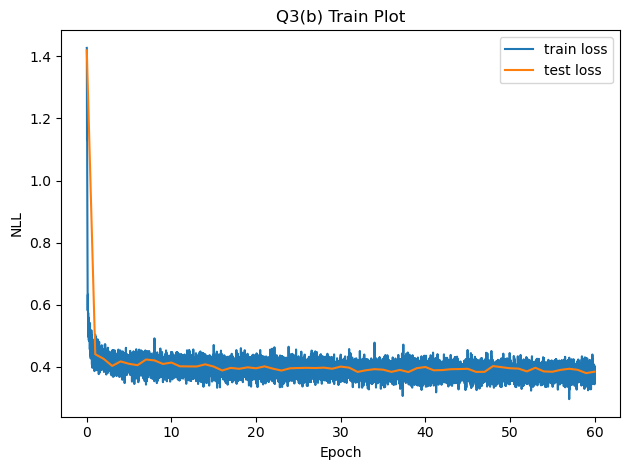

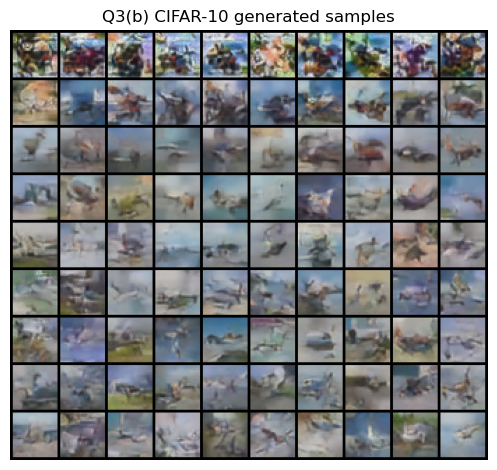

In [26]:
q3b_save_results(q3_b)

Files already downloaded and verified
Files already downloaded and verified
(9, 10, 32, 32, 3)
Final Test Loss: 0.3899


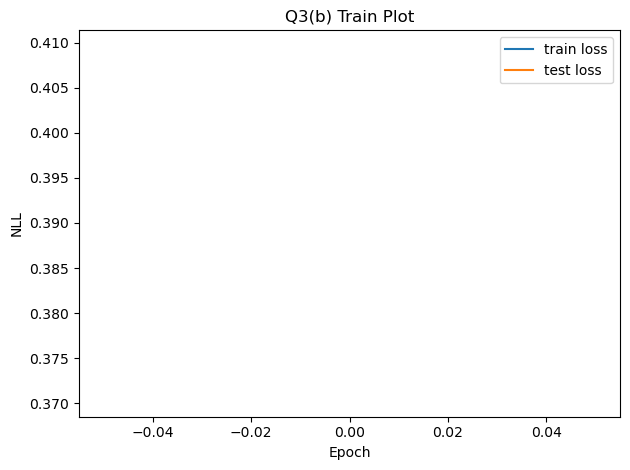

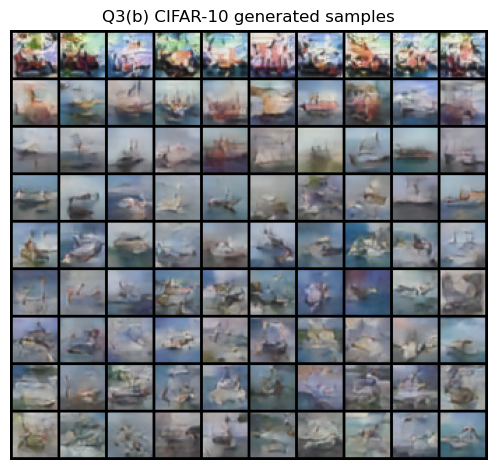

In [40]:

def q3_b_sample(train_data, train_labels, test_data, test_labels, vae):
    """
    train_data: A (50000, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (50000,) numpy array of class labels
    test_data: A (10000, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (10000,) numpy array of class labels
    vae: a pretrained VAE

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 10 x 10 grid of generated samples. Each row represents 10 samples generated
      for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use 512 diffusion timesteps
    """

    """ YOUR CODE HERE """
    #  data is between 0 and 1
    # mean, std = train_data.mean(), train_data.std()
    train_data = vae_encode(train_data, vae)
    test_data = vae_encode(test_data, vae)

    num_epochs = 60  # blows up at 35
    batch_size = 256
    learning_rate = 1e-3
    warmup_steps = 100
    total_steps = num_epochs * (train_data.shape[0] // batch_size)

    test_losses = []
    train_losses = []

    model = DiT(input_shape=(4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12, num_classes=10, cfg_dropout_prob=0.0).to(device)
    model.eval()
    checkpoint_path = 'deepul/homeworks/hw4/data/model_q3b.pth'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    test_losses.append(q3b_loss(model, test_data, test_labels, batch_size*3))
    all_samples = []
    for step in np.power(2, np.linspace(0, 9, 9)).astype(int):
        decoded = q3b_sample(model, step, 10, class_id=8)
        decoded = vae_decode(decoded, vae)
        all_samples.append(decoded)
    samples = np.stack(all_samples, axis=0)
    print(samples.shape)
    np.save('deepul/homeworks/hw4/data/all_samples_q3b.npy', samples)

    return train_losses, test_losses, samples
q3b_save_results(q3_b_sample)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [55]:
def q3c_sample(model: torch.nn.Module, num_steps: int, num_samples: int, class_id: int, num_classes:int, w: float) -> np.ndarray:
    model.eval()
    x = torch.randn(num_samples, 4, 8, 8, device=device)
    ts = torch.linspace(1 - 1e-4, 1e-4, num_steps + 1, device=device)
    for i in range(num_steps):
        # print(f"Allocated CUDA memory: {torch.cuda.memory_allocated(device) / (1024 * 1024)} MB")

        t = ts[i]
        tm1 = ts[i + 1]
        # Prepare model input
        t_expanded = t.expand(num_samples, 1).to(device)
        # Model prediction for eps_hat
        with torch.no_grad():
            term1 = model(x, torch.ones(num_samples, dtype=torch.int32).to(device)*num_classes, t_expanded)
            term2 = model(x, torch.ones(num_samples, dtype=torch.int32).to(device)*class_id, t_expanded)
            term3 = model(x, torch.ones(num_samples, dtype=torch.int32).to(device)*num_classes, t_expanded)
            eps_hat = term1 + w * (term2 - term3)
        # Update x using the DDPM update rule
        x = DDPM_UPDATE(x, eps_hat, t, tm1)
    return x.cpu().detach().numpy()

def q3_c(vae):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, 10, 32, 32, 3) of samples in [0, 1] drawn from your model.
      The array represents a 4 x 10 x 10 grid of generated samples - 4 10 x 10 grid of samples
      with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x 10 grid
      should contain samples of a different class. Use 512 diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """

    model = DiT(input_shape=(4, 8, 8), patch_size=2, hidden_size=512, num_heads=8, num_layers=12, num_classes=10, cfg_dropout_prob=0.0).to(device)
    model.eval()
    checkpoint_path = 'deepul/homeworks/hw4/data/model_q3b.pth'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint)
    all_samples = []
    for w in [1.0, 3.0, 5.0, 7.5]:
        samples1 = []
        for class_id in range(10):
            decoded = q3c_sample(model, 512, 10, class_id=class_id, num_classes=10, w=w)
            decoded = vae_decode(decoded, vae)
            samples1.append(decoded)
        all_samples.append(np.stack(samples1, axis=0))
    samples = np.stack(all_samples, axis=0)
    return samples

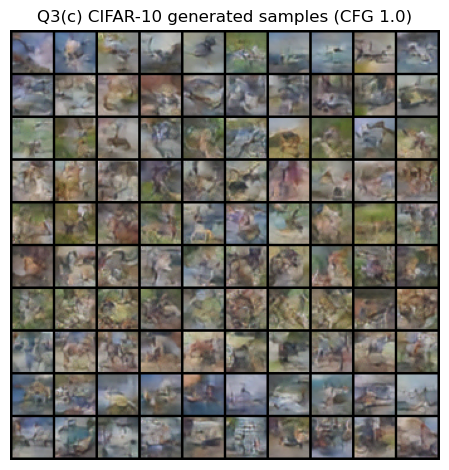

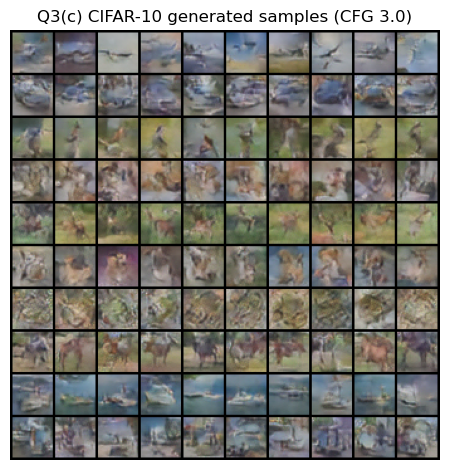

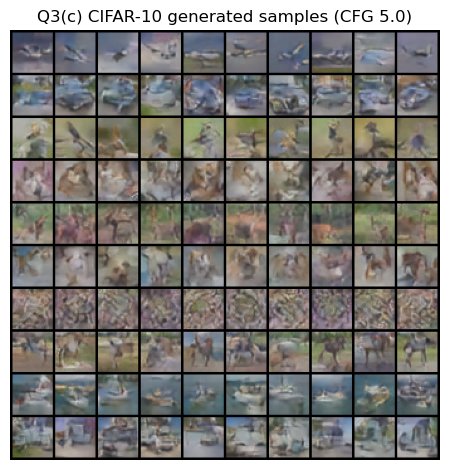

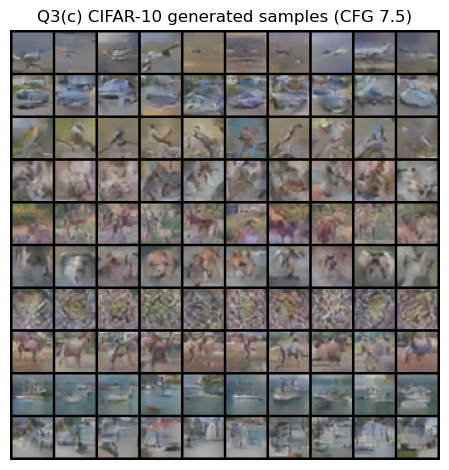

In [56]:
q3c_save_results(q3_c)